In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker quote: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jobathon-august-2022/test_Bk2wfZ3.csv
/kaggle/input/jobathon-august-2022/sample_submission_LJ2N3ZQ.csv
/kaggle/input/jobathon-august-2022/train_F3fUq2S.csv


In [3]:
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import BayesianRidge, Ridge, Lasso
import xgboost as xg
import catboost as ctb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,train_test_split
import seaborn as sn
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from numpy import sort

In [4]:
train = pd.read_csv('../input/jobathon-august-2022/train_F3fUq2S.csv')
test = pd.read_csv('../input/jobathon-august-2022/test_Bk2wfZ3.csv')
sample = pd.read_csv('../input/jobathon-august-2022/sample_submission_LJ2N3ZQ.csv')

In [5]:
train

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,Noon,6,26,...,0,0,0,0,0,0,0,0,14,0.103079
1,2,3,54,2570,256,5,1,Morning,2,11,...,0,0,0,0,0,0,0,0,10,0.700000
2,3,3,59,12801,16,5,1,Noon,2,11,...,1,0,1,0,0,0,0,0,16,0.002769
3,4,3,74,11037,30,4,0,Evening,15,9,...,0,0,0,0,0,0,0,0,10,0.010868
4,5,3,80,10011,27,5,1,Noon,6,26,...,0,0,1,0,0,0,0,0,14,0.142826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,1884,3,88,1451,75,2,0,Noon,2,11,...,0,0,1,0,0,0,0,0,10,0.350746
1884,1885,3,58,10537,40,2,0,Evening,2,11,...,0,0,0,0,0,0,0,0,11,0.004728
1885,1886,3,89,11050,26,1,0,Evening,15,9,...,0,0,0,0,0,0,0,0,6,0.008289
1886,1887,3,58,10537,40,1,0,Evening,2,11,...,0,0,0,0,0,0,0,0,16,0.012014


In [6]:
train.isnull().sum()

campaign_id           0
sender                0
subject_len           0
body_len              0
mean_paragraph_len    0
day_of_week           0
is_weekend            0
times_of_day          0
category              0
product               0
no_of_CTA             0
mean_CTA_len          0
is_image              0
is_personalised       0
is_quote              0
is_timer              0
is_emoticons          0
is_discount           0
is_price              0
is_urgency            0
target_audience       0
click_rate            0
dtype: int64

# Data Visualization


<AxesSubplot:xlabel='is_urgency', ylabel='click_rate'>

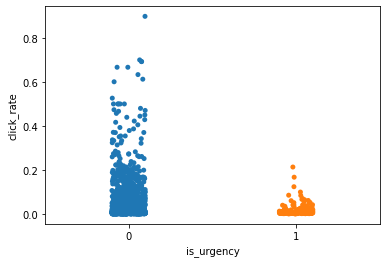

In [7]:
sn.stripplot(x="is_urgency", y="click_rate", data=train)

<AxesSubplot:xlabel='no_of_CTA', ylabel='click_rate'>

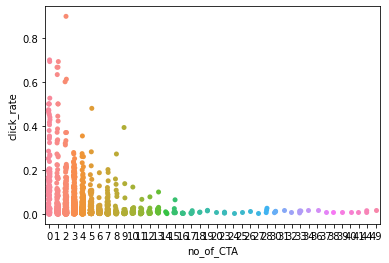

In [8]:
sn.stripplot(x="no_of_CTA", y="click_rate", data=train)

<AxesSubplot:xlabel='mean_CTA_len', ylabel='click_rate'>

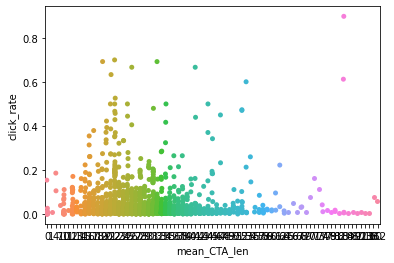

In [9]:
sn.stripplot(x="mean_CTA_len", y="click_rate", data=train)

<AxesSubplot:xlabel='mean_CTA_len', ylabel='click_rate'>

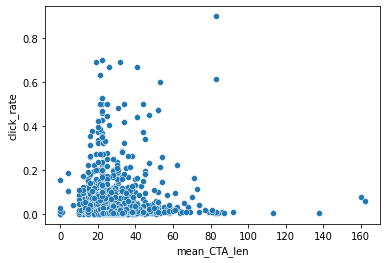

In [10]:
sn.scatterplot(x = 'mean_CTA_len', y = 'click_rate', data = train)

<AxesSubplot:xlabel='no_of_CTA', ylabel='click_rate'>

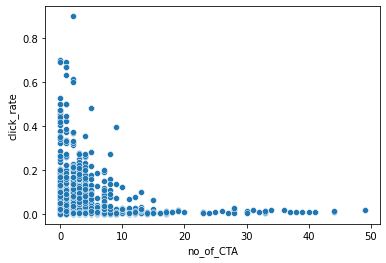

In [11]:
sn.scatterplot(x = 'no_of_CTA', y = 'click_rate', data = train)

In [12]:
td = train[['no_of_CTA', 'mean_CTA_len', 'click_rate']][train['no_of_CTA'] == 0]
td.reset_index(drop = True, inplace = True)

In [13]:
td

,no_of_CTA,mean_CTA_len,click_rate
0,0,22,0.700000
1,0,22,0.500000
2,0,22,0.457143
3,0,26,0.405204
4,0,22,0.014538
...,...,...,...
110,0,22,0.354545
111,0,22,0.131313
112,0,22,0.201923
113,0,22,0.169014


In [14]:
td[td['click_rate']  == 0]

,no_of_CTA,mean_CTA_len,click_rate
20,0,0,0.0
34,0,0,0.0
35,0,0,0.0
44,0,0,0.0
85,0,0,0.0


In [15]:
td[td['mean_CTA_len'] == 0]

,no_of_CTA,mean_CTA_len,click_rate
20,0,0,0.0
34,0,0,0.0
35,0,0,0.0
44,0,0,0.0
85,0,0,0.0


<AxesSubplot:xlabel='mean_CTA_len', ylabel='click_rate'>

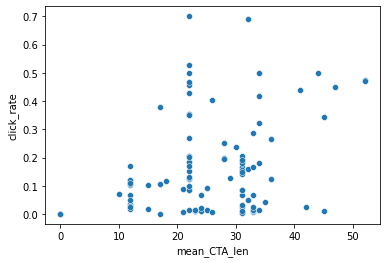

In [16]:
sn.scatterplot(x = 'mean_CTA_len', y = 'click_rate', data = td)

<AxesSubplot:xlabel='click_rate', ylabel='mean_CTA_len'>

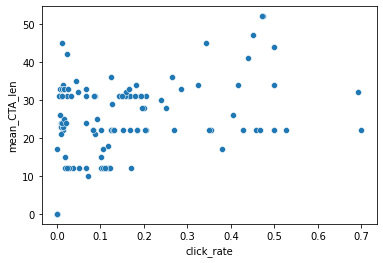

In [17]:
sn.scatterplot(y = 'mean_CTA_len', x = 'click_rate', data = td)

<AxesSubplot:xlabel='mean_CTA_len', ylabel='click_rate'>

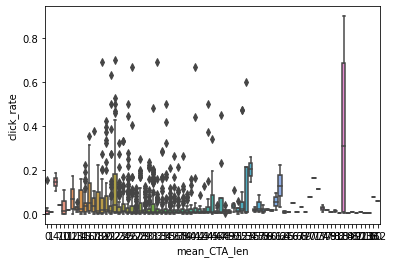

In [18]:
sn.boxplot(data = train, x = 'mean_CTA_len', y = 'click_rate')

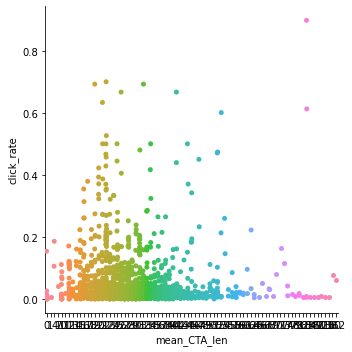

In [19]:
sn.catplot(data = train, x = 'mean_CTA_len', y = 'click_rate')

<AxesSubplot:xlabel='mean_CTA_len', ylabel='click_rate'>

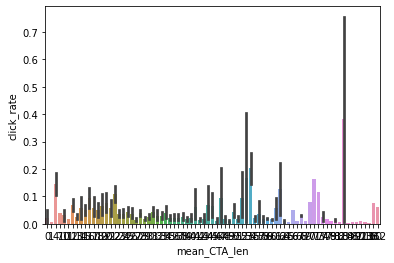

In [20]:
sn.barplot(data = train, x = 'mean_CTA_len', y = 'click_rate')

<AxesSubplot:xlabel='mean_CTA_len', ylabel='click_rate'>

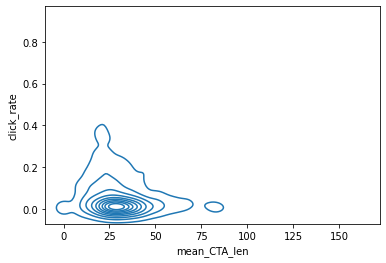

In [21]:
sn.kdeplot(data = train, x = 'mean_CTA_len', y = 'click_rate')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean_CTA_len', ylabel='Density'>

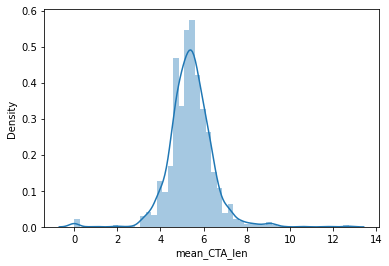

In [42]:
sn.distplot(train['mean_CTA_len']**(1/2))
# sn.distplot(train['click_rate']);

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='no_of_CTA', ylabel='Density'>

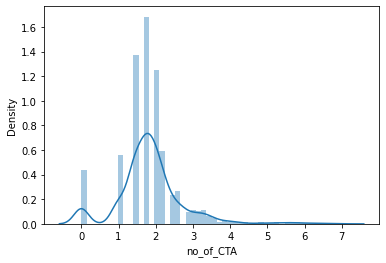

In [54]:
sn.distplot(np.sqrt(train['no_of_CTA']))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


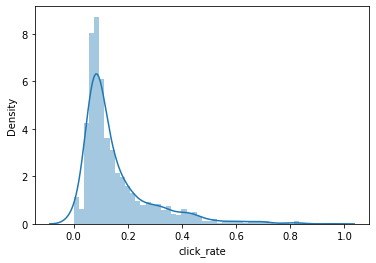

In [53]:
sn.distplot(train['click_rate']**(1/2));

In [25]:
hm = pd.get_dummies(train, columns = ['times_of_day'], drop_first = True)
train.corr()
# sn.heatmap(hm)

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,category,product,no_of_CTA,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
campaign_id,1.000000,0.443314,-0.052252,0.200128,0.028225,0.036410,0.051932,0.289416,0.209435,0.117558,...,-0.022799,0.219755,-0.006662,NaN,-0.128840,-0.002232,-0.041955,-0.058105,-0.104905,0.053315
sender,0.443314,1.000000,-0.102559,0.197929,0.056891,-0.046928,-0.059499,0.188444,0.070689,0.100454,...,-0.093244,0.147959,0.020928,NaN,-0.105279,-0.046900,0.024099,-0.071096,-0.132554,-0.031398
subject_len,-0.052252,-0.102559,1.000000,0.427326,-0.224770,-0.033574,-0.056666,0.012601,-0.007108,0.400213,...,-0.002214,-0.293446,0.120273,NaN,0.080303,0.125134,0.033410,0.100584,-0.021855,-0.180143
body_len,0.200128,0.197929,0.427326,1.000000,-0.496146,-0.089146,-0.079255,0.026781,-0.027747,0.559353,...,-0.021254,-0.220696,0.184035,NaN,-0.043931,0.051123,0.022431,0.023734,-0.075754,-0.247866
mean_paragraph_len,0.028225,0.056891,-0.224770,-0.496146,1.000000,0.003221,-0.012964,0.037475,-0.054066,-0.170012,...,-0.091250,0.162480,-0.096086,NaN,-0.043173,-0.032096,0.006765,-0.037435,-0.110896,0.178042
day_of_week,0.036410,-0.046928,-0.033574,-0.089146,0.003221,1.000000,0.720599,-0.058760,0.000249,-0.037789,...,0.019365,-0.069705,-0.032476,NaN,-0.013571,-0.037122,-0.013822,0.012735,0.081693,0.086372
is_weekend,0.051932,-0.059499,-0.056666,-0.079255,-0.012964,0.720599,1.000000,-0.063763,-0.015759,-0.033464,...,0.036626,-0.065130,-0.033968,NaN,-0.007504,-0.033757,-0.036255,-0.009789,0.046638,0.114138
category,0.289416,0.188444,0.012601,0.026781,0.037475,-0.058760,-0.063763,1.000000,0.007144,-0.023931,...,-0.028794,0.132441,-0.101411,NaN,0.100071,0.166200,0.068450,0.189839,-0.026602,-0.167756
product,0.209435,0.070689,-0.007108,-0.027747,-0.054066,0.000249,-0.015759,0.007144,1.000000,0.027486,...,0.027952,0.047566,-0.104653,NaN,0.013122,-0.018291,-0.060512,-0.110753,0.058073,0.121602
no_of_CTA,0.117558,0.100454,0.400213,0.559353,-0.170012,-0.037789,-0.033464,-0.023931,0.027486,1.000000,...,-0.005971,-0.145453,0.092320,NaN,-0.037244,0.041797,-0.015229,-0.015649,-0.007979,-0.172637


<AxesSubplot:xlabel='sender', ylabel='click_rate'>

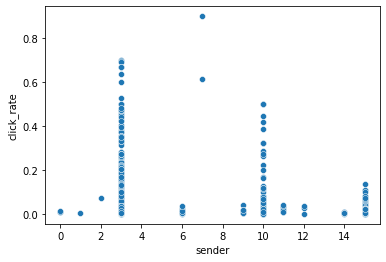

In [55]:
sn.scatterplot(x = train['sender'], y = train['click_rate'])

<AxesSubplot:xlabel='category', ylabel='click_rate'>

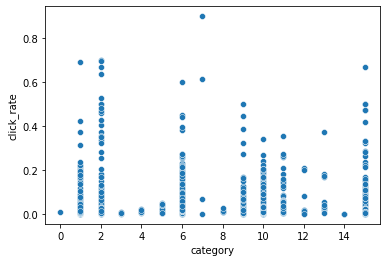

In [56]:
sn.scatterplot(x = train['category'], y = train['click_rate'])

<AxesSubplot:xlabel='product', ylabel='click_rate'>

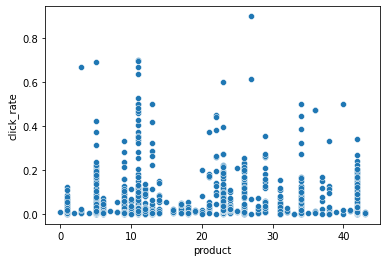

In [57]:
sn.scatterplot(x = train['product'], y = train['click_rate'])

In [26]:
z

NameError: name 'z' is not defined

In [ ]:
hi

In [ ]:
sn.countplot(train['sender'])

In [ ]:
sn.histplot(train['sender'])

In [ ]:
train.drop(['campaign_id', 'is_timer'], axis = 1, inplace = True)
test.drop(['campaign_id', 'is_timer'], axis = 1, inplace = True)

In [ ]:
train

In [ ]:
train.describe()

In [ ]:
train['sender'].value_counts()

In [ ]:
test['sender'].value_counts()

In [ ]:
train.info()

In [ ]:
train['is_quote'].value_counts()

In [ ]:
train[train['no_of_CTA'] == 0]

In [ ]:
train[(train['no_of_CTA'] == 0) & (train['mean_CTA_len'] == 0)]

In [ ]:
test[(test['no_of_CTA'] == 0) & (test['mean_CTA_len'] == 0)]

In [ ]:
train[train['is_quote'] == 2]

In [ ]:
test['is_quote'].value_counts()

In [ ]:
train['is_quote'].value_counts()

In [ ]:
train['is_emoticons'].value_counts()

In [ ]:
train['is_price'].value_counts()

In [ ]:
test['is_price'].value_counts()

In [ ]:
# train['is_timer'].value_counts()
# test['is_timer'].value_counts()

In [ ]:
train.corr()

In [ ]:
train['times_of_day'].value_counts()

In [ ]:
tr = pd.get_dummies(train, columns = ['times_of_day'], drop_first = True)
te = pd.get_dummies(test, columns = ['times_of_day'], drop_first = True)

In [ ]:
train.corr()

In [ ]:
train.describe()

In [ ]:
# Add new features
tr['sub_body_ratio'] = tr['subject_len']/tr['body_len']
te['sub_body_ratio'] = te['subject_len']/te['body_len']

tr['body_sub_ratio'] = tr['body_len']/tr['subject_len']
te['body_sub_ratio'] = te['body_len']/te['subject_len']

tr['body_paragraph_ratio'] = tr['body_len']/tr['mean_paragraph_len']
te['body_paragraph_ratio'] = te['body_len']/te['mean_paragraph_len']

tr['paragraph_CTA_len_ratio'] = tr['mean_paragraph_len']/(tr['mean_CTA_len']+1)
te['paragraph_CTA_len_ratio'] = te['mean_paragraph_len']/(1+te['mean_CTA_len'])

tr['subj_len_CTA_no'] = tr['subject_len']/(1+ tr['no_of_CTA'])
te['subj_len_CTA_no'] = te['subject_len']/(1+ te['no_of_CTA'])

tr['body_len_CTA_no'] = tr['body_len']/(1+ tr['no_of_CTA'])
te['body_len_CTA_no'] = te['body_len']/(1+ te['no_of_CTA'])


tr['cta_mean_ratio'] = tr['no_of_CTA']/(tr['mean_CTA_len']+ 1)
te['cta_mean_ratio'] = te['no_of_CTA']/(te['mean_CTA_len']+ 1)

In [ ]:
tr['img_encode_0'] = np.where(tr['is_image'] == 0, 1, 0)
te['img_encode_0'] = np.where(te['is_image'] == 0, 1, 0)

tr['img_encode_1'] = np.where(tr['is_image'] == 1, 1, 0)
te['img_encode_1'] = np.where(te['is_image'] == 1, 1, 0)

tr['img_encode_2'] = np.where(tr['is_image'] == 2, 1, 0)
te['img_encode_2'] = np.where(te['is_image'] == 2, 1, 0)

tr['img_encode_3'] = np.where(tr['is_image'] == 3, 1, 0)
te['img_encode_3'] = np.where(te['is_image'] == 3, 1, 0)

tr['img_encode_4'] = np.where(tr['is_image'] == 4, 1, 0)
te['img_encode_4'] = np.where(te['is_image'] == 4, 1, 0)

tr['img_encode_5'] = np.where(tr['is_image'] == 5, 1, 0)
te['img_encode_5'] = np.where(te['is_image'] == 5, 1, 0)

tr['img_encode_6'] = np.where(tr['is_image'] == 6, 1, 0)
te['img_encode_6'] = np.where(te['is_image'] == 6, 1, 0)

In [ ]:
tr['quote_encode_0'] = np.where(tr['is_quote'] == 0, 1, 0)
te['quote_encode_0'] = np.where(te['is_quote'] == 0, 1, 0)

tr['quote_encode_1'] = np.where(tr['is_quote'] == 1, 1, 0)
te['quote_encode_1'] = np.where(te['is_quote'] == 1, 1, 0)

tr['quote_encode_2'] = np.where(tr['is_quote'] == 2, 1, 0)
te['quote_encode_2'] = np.where(te['is_quote'] == 2, 1, 0)

tr['quote_encode_3'] = np.where(tr['is_quote'] == 3, 1, 0)
te['quote_encode_3'] = np.where(te['is_quote'] == 3, 1, 0)

tr['quote_encode_4'] = np.where(tr['is_quote'] == 4, 1, 0)
te['quote_encode_4'] = np.where(te['is_quote'] == 4, 1, 0)

tr['quote_encode_5'] = np.where(tr['is_quote'] == 5, 1, 0)
te['quote_encode_5'] = np.where(te['is_quote'] == 5, 1, 0)

tr['quote_encode_6'] = np.where(tr['is_quote'] == 6, 1, 0)
te['quote_encode_6'] = np.where(te['is_quote'] == 6, 1, 0)

In [ ]:
tr['emoticons_encode_0'] = np.where(tr['is_emoticons'] == 0, 1, 0)
te['emoticons_encode_0'] = np.where(te['is_emoticons'] == 0, 1, 0)

tr['emoticons_encode_1'] = np.where(tr['is_emoticons'] == 1, 1, 0)
te['emoticons_encode_1'] = np.where(te['is_emoticons'] == 1, 1, 0)

tr['emoticons_encode_2'] = np.where(tr['is_emoticons'] == 2, 1, 0)
te['emoticons_encode_2'] = np.where(te['is_emoticons'] == 2, 1, 0)

tr['emoticons_encode_3'] = np.where(tr['is_emoticons'] == 3, 1, 0)
te['emoticons_encode_3'] = np.where(te['is_emoticons'] == 3, 1, 0)

tr['emoticons_encode_4'] = np.where(tr['is_emoticons'] == 4, 1, 0)
te['emoticons_encode_4'] = np.where(te['is_emoticons'] == 4, 1, 0)

tr['emoticons_encode_5'] = np.where(tr['is_emoticons'] == 5, 1, 0)
te['emoticons_encode_5'] = np.where(te['is_emoticons'] == 5, 1, 0)

tr['emoticons_encode_6'] = np.where(tr['is_emoticons'] == 6, 1, 0)
te['emoticons_encode_6'] = np.where(te['is_emoticons'] == 6, 1, 0)

In [ ]:
for i in range(16):
    tr['sender_'+str(i)] = np.where(tr['sender'] == i, 1, 0)
    te['sender_'+str(i)] = np.where(te['sender'] == i, 1, 0)

In [ ]:
# tr['day_of_week'] = np.sin(tr['day_of_week'])
# te['day_of_week'] = np.sin(te['day_of_week'])

In [ ]:
tr

In [ ]:
# tr.drop(['is_image', 'is_quote', 'is_emoticons', 'sender', 'category', 'product', 'is_price', 'target_audience'], axis = 1, inplace = True)
# te.drop(['is_image', 'is_quote', 'is_emoticons', 'sender', 'category', 'product', 'is_price', 'target_audience'], axis = 1, inplace = True)

In [ ]:
tr

In [ ]:
# # tr['quote_body_ratio'] = tr['is_quote']/tr['body_len']
# tr['quote_quote_ratio'] = tr['is_quote']/max(1, tr['is_quote'])
# te['quote_quote_ratio'] = te['is_quote']/max(1, te['is_quote'])


# tr['quote_price_ratio'] = tr['is_quote']/max(1, tr['is_price'])
# te['quote_price_ratio'] = te['is_quote']/max(1, te['is_price'])

# tr['quote_emoticons_ratio'] = tr['is_quote']/max(1, tr['is_emoticons'])
# te['quote_emoticons_ratio'] = te['is_quote']/max(1, te['is_emoticons'])


In [ ]:
tr.isnull().sum()

In [ ]:
# tr.drop('day_of_week', axis = 1, inplace = True)
# te.drop('day_of_week', axis = 1, inplace = True)

In [ ]:
X = tr.drop('click_rate', axis = 1)
y = tr['click_rate']**(1/6)

In [ ]:
X

In [ ]:
y_bins = pd.qcut(tr['click_rate'], 5, labels=[1,2,3,4,5]).astype(int)

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y_bins)

In [ ]:
# xgb = xg.XGBRegressor()
# xgb.fit(X_train,y_train)
# eval_set = [(X_test, y_test)]
model = xg.XGBRegressor(random_state=42)
# model = lgbm.LGBMRegressor()
# model = Lasso()
# model = RandomForestRegressor(random_state = 43)
# model = DecisionTreeRegressor(random_state = 43) 
# model = ctb.CatBoostRegressor(random_state = 42)
# model = AdaBoostRegressor(random_state = 42)
model.fit(X_train, y_train)
#           eval_set = eval_set, early_stopping_rounds=30)

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred = y_pred**6
y_pred_train = y_pred_train**6
print(r2_score(y_train**6,y_pred_train))
print(r2_score(y_test**6, y_pred))

One hot encode of time of day\
0.9839462262072959\
0.5621476014976081

In [ ]:
# x = tr.drop('click_rate', axis = 1)
# y = tr['click_rate']                    


# Feature Scaling for input features.
# scaler = preprocessing.MinMaxScaler()
# x_scaled = scaler.fit_transform(x)
  
# Create  classifier object.
# xgb = xg.XGBRegressor()
# xgb.fit(x,y)
# Create StratifiedKFold object.
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# lst_accu_stratified = []
  
# for train_index, test_index in skf.split(x, y):
#     x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
#     y_train_fold, y_test_fold = y[train_index], y[test_index]
#     xgb.fit(x_train_fold, y_train_fold)
#     lst_accu_stratified.append(xgb.score(x_test_fold, y_test_fold))

In [ ]:
model.feature_importances_

In [ ]:
# pred

# plot feature importance
plt.rcParams["figure.figsize"] = (14, 11)
plot_importance(model)
plt.show()

In [ ]:
new = SelectKBest(chi2, k=20).fit_transform(X, y)

In [ ]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xg.XGBRegressor(random_state = 42)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    r2score = r2_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, r2-score: %.2f%%" % (thresh, select_X_train.shape[1], r2score*100.0))


In [ ]:
# pred = xgb.predict(te)
# test.drop(['is_image', 'is_quote', 'is_emoticons', 'sender', 'category', 'product', 'is_price', 'target_audience', 'day_of_week'], axis = 1, inplace = True)
pred = model.predict(te)
sample['click_rate'] = pred ** 6

In [ ]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'r2')
print(scores)
print(np.mean(scores))
# sample

In [ ]:
sample.to_csv('xgb_removed_features.csv', index = False)